# Blackbird Force Estimation

The blackbird position estimation is currently taken from the camera system at ~360 Hz. Using the position information, this notebook will look at various ways to numerically estimate the velocity and acceleration along the flight test.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../functions'))
import read_blackbird_dataset as rbd

test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)

In [2]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216365 entries, 1526617312016142000 to 1526617526753759000
Data columns (total 37 columns):
PWM1                              39823 non-null float64
PWM2                              39823 non-null float64
PWM3                              39823 non-null float64
PWM4                              39823 non-null float64
angular_velocity_covariance       21298 non-null object
ax_[m/s2]                         21298 non-null float64
ay_[m/s2]                         21298 non-null float64
az_[m/s2]                         21298 non-null float64
linear_acceleration_covariance    21298 non-null object
omegax_[dps]                      21298 non-null float64
omegay_[dps]                      21298 non-null float64
omegaz_[dps]                      21298 non-null float64
orientation_covariance            21298 non-null object
pitch_[rad]                       77286 non-null float64
pitch_ref_[rad]                   38130 non-null float64
px_[m]

<IPython.core.display.Javascript object>


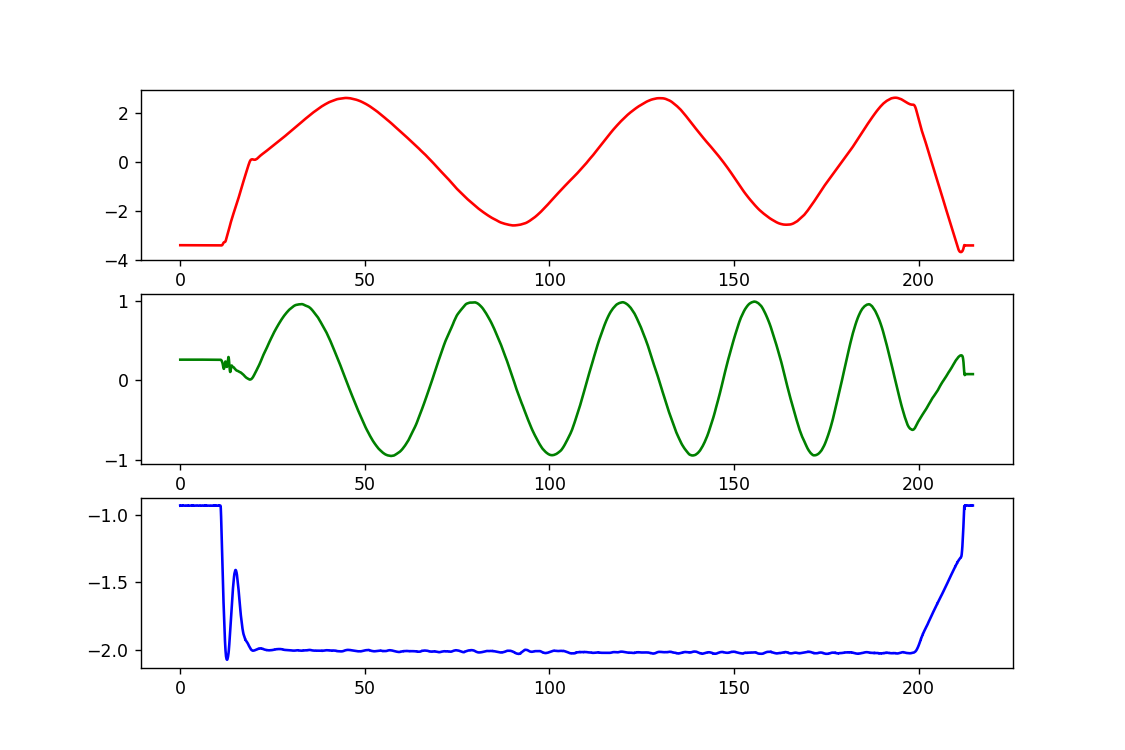

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

rbts2s = 10 ** -9
tvec = (test_df.index - test_df.index[0])*rbts2s

fig, ax = plt.subplots(3,1)
fig.set_size_inches(9,6)
ax[0].plot(tvec, test_df['px_[m]'], color='r')
ax[1].plot(tvec, test_df['py_[m]'], color='g')
ax[2].plot(tvec, test_df['pz_[m]'], color='b')

plt.show()

In [12]:
# Numpy second order central difference
import numpy as np

x = test_df['px_[m]'].values
y = test_df['py_[m]'].values
z = test_df['pz_[m]'].values

vx = np.gradient(x, tvec)
vy = np.gradient(y, tvec)
vz = np.gradient(z, tvec)

vmag = (vx**2 + vy**2 + vz**2) ** (1/2)

<IPython.core.display.Javascript object>


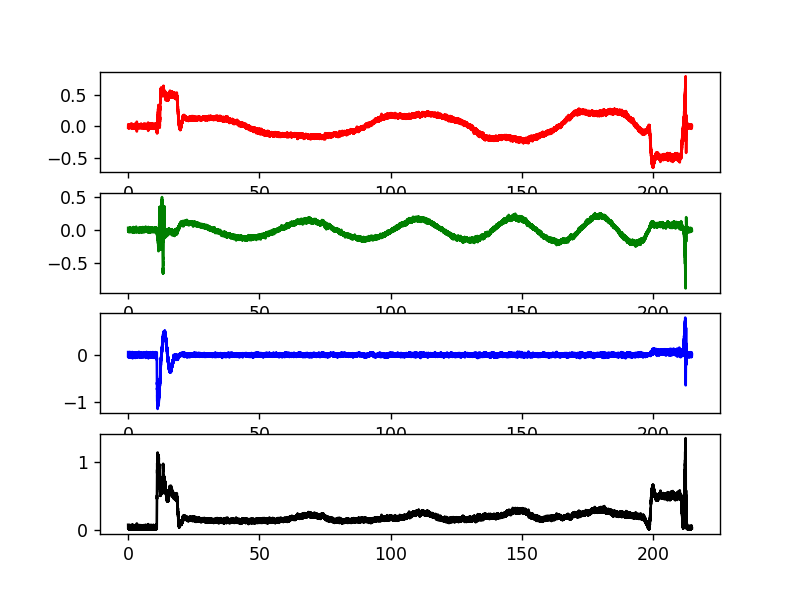

In [13]:
fig, ax = plt.subplots(4,1)

ax[0].plot(tvec, vx, color='r')
ax[1].plot(tvec, vy, color='g')
ax[2].plot(tvec, vz, color='b')
ax[3].plot(tvec, vmag, color='k')

plt.show()

In [22]:
# Numpy second order central difference

ax = np.gradient(vx, tvec)
ay = np.gradient(vy, tvec)
az = np.gradient(vz, tvec)

amag = (ax**2 + ay**2 + az**2) ** (1/2)
print(ax.shape)
print(tvec.shape)

(216365,)
(216365,)


<IPython.core.display.Javascript object>


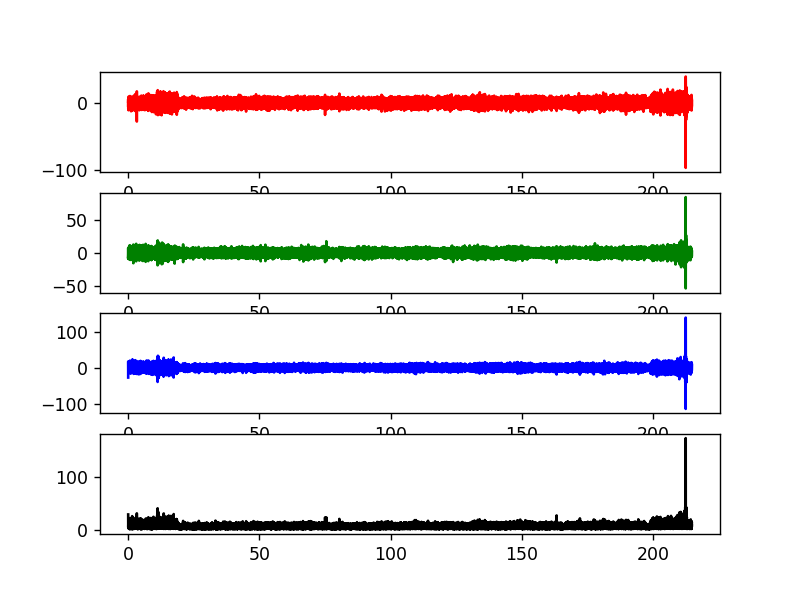

In [23]:
fig, axis = plt.subplots(4,1)

axis[0].plot(tvec, ax, color='r')
axis[1].plot(tvec, ay, color='g')
axis[2].plot(tvec, az, color='b')
axis[3].plot(tvec, amag, color='k')

plt.show()

In [ ]:
# Creating function for arbitary polynomial fitting
def central_sg_filter(tvec, xvec, m=5, window=13):
    """
    Based off the Savitzky-Golay filter which uses a least-squares estimation to determine a local polynomial. 
    
    Parameters:
        tvec   = (n,) numpy array for time vector which is not uniform
        xvec   = (n,) numpy array of the noise time
        m      = mth order polynomial
        window = number of points to be looking at. Should be odd so that the smoothing is being done 
                [-(j-1)/2,...,-1,0,1,...,(j-1)/2]
    
    Output:
        cs = (n,m+1)
        
    Reference: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    
    #Initialize vectors
    n = tvec.shape[0]
    cs = np.zeros((n,m+1))
    hs = (window - 1)/2
    
    for i in range(hs, n-hs):
        tlocal = tvec[i-hs:i+hs] - tvec[i]
        y      = xvec[i-hs:i+hs]
        X = np.outer(tlocal, np.ones((m+1,)))
        for j in range(m+1):
            X[:,j] = X[:,j] ** j
        Xt = np.transpose(X)
        theta = np.matmul(np.invert(np.matmul(Xt,X)),
                          np.matmul(Xt, np.transpose(y)))
        cs[i,:] = theta
    
    return cs